# Import libraries and read data



In [ ]:
from google.colab import auth
from collections import Counter
import shutil
from tqdm import tqdm_notebook as tqdm
from random import randint
%matplotlib inline
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/6.8610proj/dataset_ready.csv')

In [ ]:
import torch

debiased_n1000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n1000.pt', map_location=torch.device('cpu'))
debiased_n2000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n2000.pt', map_location=torch.device('cpu'))
debiased_n5000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n5000.pt', map_location=torch.device('cpu'))
debiased_n3000 = torch.load('/content/drive/MyDrive/weights/debiased_fusion_n3000.pt', map_location=torch.device('cpu'))

In [ ]:
n1000 = torch.load('/content/drive/MyDrive/weights/fusion_n1000.pt', map_location=torch.device('cpu'))
n2000 = torch.load('/content/drive/MyDrive/weights/fusion_n2000.pt', map_location=torch.device('cpu'))
n3000 = torch.load('/content/drive/MyDrive/weights/fusion_n3000.pt', map_location=torch.device('cpu'))
n5000 = torch.load('/content/drive/MyDrive/weights/fusion_n5000.pt', map_location=torch.device('cpu'))

# Transformer Explanation

In [ ]:
from transformers import DistilBertModel, AutoTokenizer
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
resnet = torch.nn.Sequential(*list(resnet50(weights=ResNet50_Weights.DEFAULT).children())[:-1])

# Modified MultiModalModel class to output attention scores from BERT
class MultiModalModel(nn.Module):
    """
    Model that outputs representations for image and text
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(MultiModalModel, self).__init__()
        self.tokenizer = tokenizer
        self.nlp_encoder = nlp_encoder
        self.nlp_out = nn.Linear(768, 256) # bert
        self.cv_encoder = cv_encoder
        self.cv_out = nn.Linear(2048, 256) # resnet

    def forward(self, im, text, return_attentions=False):
        # Process text
        tokens = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True).to(device)
        outputs = self.nlp_encoder(**tokens, output_attentions=return_attentions)
        z_text = outputs.last_hidden_state
        z_text = self.nlp_out(z_text).mean(axis=1)

        if im is not None:
            z_im = self.cv_encoder(im).squeeze()
            z_im = self.cv_out(z_im)
        else:
            z_im = torch.zeros((z_text.shape[0], 256), device=device)  # Placeholder for image features

        if return_attentions:
            attentions = outputs.attentions
            return z_im, z_text, attentions
        return z_im, z_text

# Define the FusionModel class
class FusionModel(nn.Module):
    """
    Model that performs intermediate fusion and outputs logits
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(FusionModel, self).__init__()
        multimodal_encoder = MultiModalModel(cv_encoder, nlp_encoder, tokenizer)
        self.multimodal_endover = multimodal_encoder
        self.out = nn.Linear(512, 2)

    def forward(self, im, text):
        z_im, z_text = self.multimodal_endover(im, text)
        z = torch.cat([z_im, z_text], axis = 1)
        z = self.out(z)
        return z
    def get_text_attention_scores(self, text):
        # Process only text, image input is None
        _, _, attentions = self.multimodal_endover(None, text, return_attentions=True)
        return attentions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


In [ ]:
model = FusionModel(resnet, bert, tokenizer)
model.load_state_dict(torch.load('/content/drive/MyDrive/weights/fusion_n5000.pt'))
model = model.to(device)
text_input = 'FINAL REPORT EXAMINATION:  CHEST (PA AND LAT) INDICATION:  ___ year old female ex-smoker with intermittent persistent cough // r/o infiltrate COMPARISON:  ___.IMPRESSION: As compared to the previous radiograph, the lungs are now well expanded and show normal structure and transparency. Mild elongation of the descending aorta. Normal hilar and mediastinal contours.'
attention_scores = model.get_text_attention_scores(text_input)

In [ ]:
from transformers import DistilBertModel, AutoTokenizer
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

def calculate_word_attributions(attentions, tokenizer, text):
    tokenized_text = tokenizer.tokenize(text)
    attn_matrix = attentions[-1].mean(dim=1)  # Use the last layer's attention and average over all heads
    attn_matrix = attn_matrix.squeeze(0)
    attn_scores = attn_matrix.sum(dim=0)

    # Normalize scores
    attn_scores = attn_scores / attn_scores.sum()

    # Pair tokens with their attention scores
    word_attributions = [(token, score.item()) for token, score in zip(tokenized_text, attn_scores)]
    return word_attributions

# Example usage
# text_input = 'There is no evidence of pleural effusion'
# attention_scores = model.get_text_attention_scores(text_input)
word_attributions = calculate_word_attributions(attention_scores, tokenizer, text_input)

print(word_attributions)


[('final', 0.0021648395340889692), ('report', 0.00020358308393042535), ('examination', 0.0002451911859679967), (':', 0.0002529093762859702), ('chest', 0.00027932552620768547), ('(', 0.0013942450750619173), ('pa', 0.00021402705169748515), ('and', 0.0011135347886011004), ('la', 0.0004454765876289457), ('##t', 0.0004962279344908893), (')', 0.00024842642596922815), ('indication', 0.19068403542041779), (':', 0.0002127846091752872), ('_', 0.00013582831888925284), ('_', 0.00025755309616215527), ('_', 0.00017255410784855485), ('year', 0.00018125637143384665), ('old', 0.000270947755780071), ('female', 0.0004036752216052264), ('ex', 0.0010721791768446565), ('-', 0.001285454141907394), ('smoke', 0.00033158535370603204), ('##r', 0.006083137821406126), ('with', 0.0005583931342698634), ('intermittent', 0.0016168447909876704), ('persistent', 0.005070886109024286), ('cough', 0.0013663613935932517), ('/', 0.007169210352003574), ('/', 0.0005412050522863865), ('r', 0.00043284407001920044), ('/', 0.000330

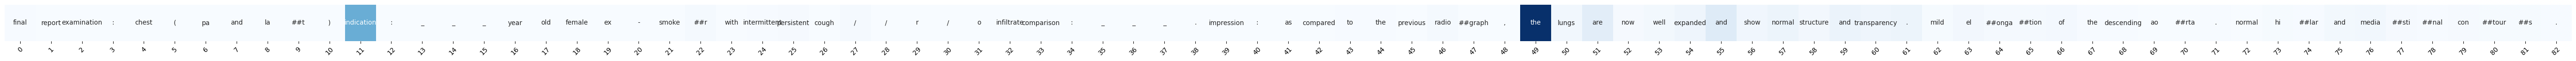

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attributions(word_attributions):
    # Extract tokens and scores
    tokens, scores = zip(*word_attributions)

    # Create a heatmap
    plt.figure(figsize=(len(tokens) * 0.85, 1))
    sns.heatmap([scores], annot=[tokens], fmt="", cmap="Blues", cbar=False, xticklabels=True)
    plt.yticks([])
    plt.xticks(rotation=45)
    plt.show()

visualize_attributions(word_attributions)

Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors


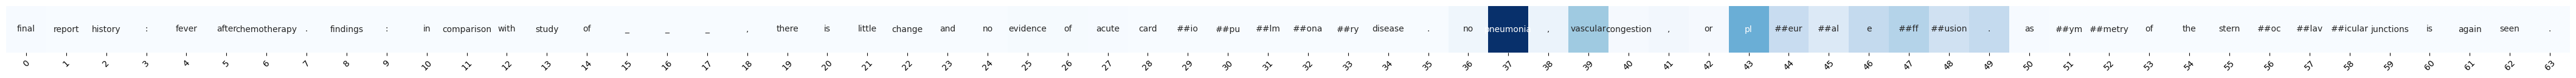

Visualizations for race group: Black/African Descent, example index: 662


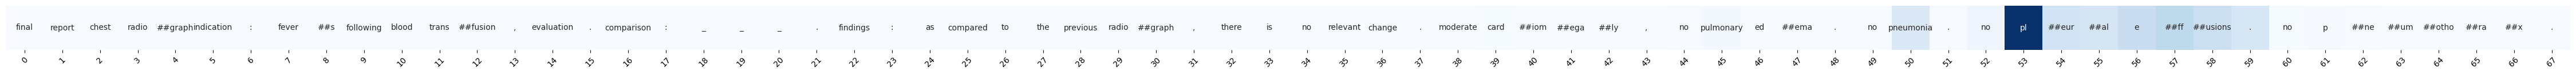

Visualizations for race group: Asian, example index: 896


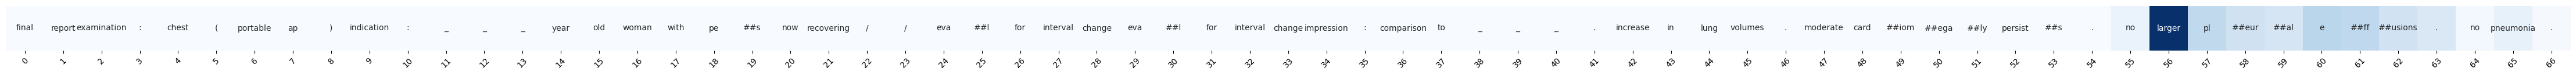

Visualizations for race group: White/Caucasian, example index: 137


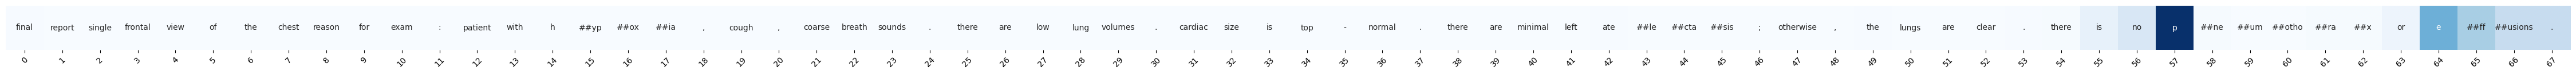

Visualizations for race group: Hispanic/Latino, example index: 2450


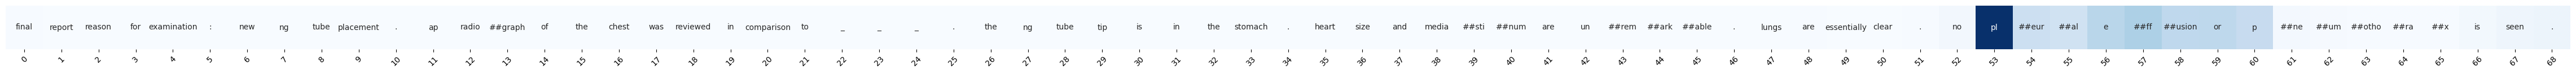

Visualizations for race group: Other Races, example index: 458


In [ ]:
model = FusionModel(resnet, bert, tokenizer)
model.load_state_dict(torch.load('/content/drive/MyDrive/weights/debiased_fusion_n5000.pt'))
model = model.to(device)

token_limit = 70

def token_count(text):
    return len(tokenizer.tokenize(text))

# Iterate through each race group
for race_group in df['general_race_group'].unique():
    # Filter DataFrame for reports with token count less than or equal to the limit
    filtered_examples = df[(df['general_race_group'] == race_group) & (df['reports'].apply(token_count) <= token_limit)]

    # Selecting two examples from the filtered group
    examples = filtered_examples.head(1)

    for index, row in examples.iterrows():
        # Extract the report text
        text_input = row['reports']

        # Get attention scores and word attributions
        attention_scores = model.get_text_attention_scores(text_input)
        word_attributions = calculate_word_attributions(attention_scores, tokenizer, text_input)

        # Visualize attributions for each example
        visualize_attributions(word_attributions)
        print(f"Visualizations for race group: {race_group}, example index: {index}")

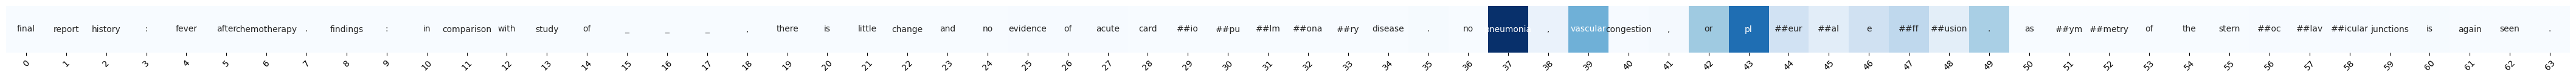

Visualizations for race group: Black/African Descent, example index: 662


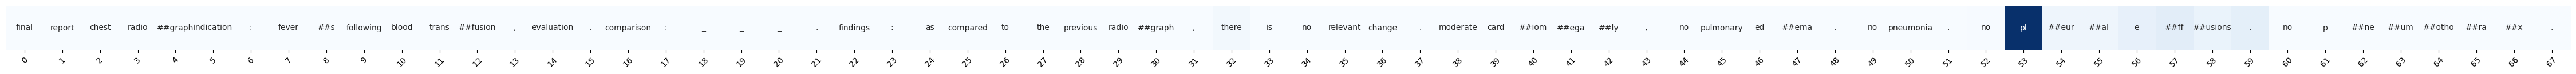

Visualizations for race group: Asian, example index: 896


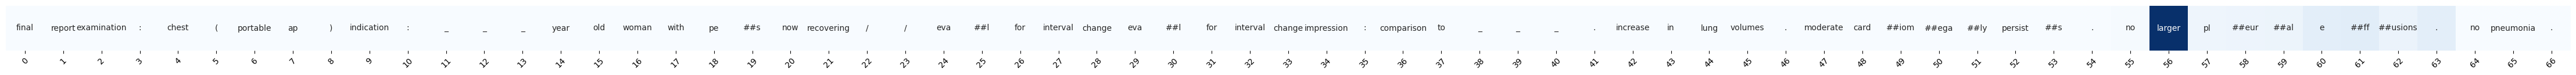

Visualizations for race group: White/Caucasian, example index: 137


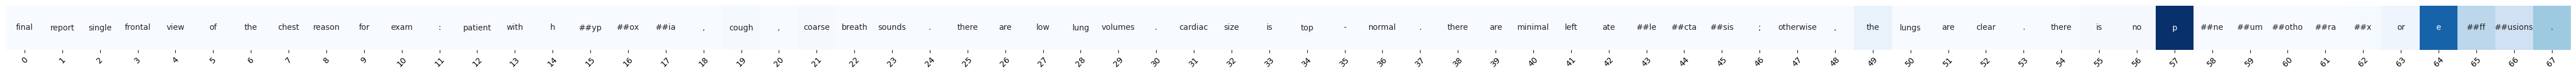

Visualizations for race group: Hispanic/Latino, example index: 2450


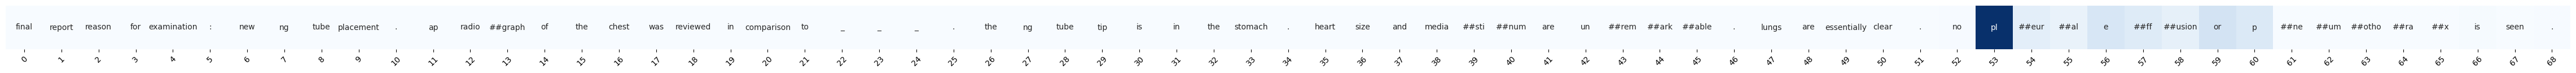

Visualizations for race group: Other Races, example index: 458


In [ ]:
model = FusionModel(resnet, bert, tokenizer)
model.load_state_dict(torch.load('/content/drive/MyDrive/weights/fusion_n5000.pt'))
model = model.to(device)

token_limit = 70

def token_count(text):
    return len(tokenizer.tokenize(text))

# Iterate through each race group
for race_group in df['general_race_group'].unique():
    # Filter DataFrame for reports with token count less than or equal to the limit
    filtered_examples = df[(df['general_race_group'] == race_group) & (df['reports'].apply(token_count) <= token_limit)]

    # Selecting two examples from the filtered group
    examples = filtered_examples.head(1)

    for index, row in examples.iterrows():
        # Extract the report text
        text_input = row['reports']

        # Get attention scores and word attributions
        attention_scores = model.get_text_attention_scores(text_input)
        word_attributions = calculate_word_attributions(attention_scores, tokenizer, text_input)

        # Visualize attributions for each example
        visualize_attributions(word_attributions)
        print(f"Visualizations for race group: {race_group}, example index: {index}")

# Vision Explanation

In [ ]:
from transformers import DistilBertModel, AutoTokenizer
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
resnet = torch.nn.Sequential(*list(resnet50(weights=ResNet50_Weights.DEFAULT).children())[:-1])

class MultiModalModel(nn.Module):
    """
    Model that outputs representations for image and text
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(MultiModalModel, self).__init__()
        self.tokenizer = tokenizer
        self.nlp_encoder = nlp_encoder
        self.nlp_out = nn.Linear(768, 256) # bert
        self.cv_encoder = cv_encoder
        self.cv_out = nn.Linear(2048, 256) # resnet

    def forward(self, im, text):
        tokens = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True).to(device)
        z_text = self.nlp_encoder(**tokens).last_hidden_state
        z_text = self.nlp_out(z_text).mean(axis = 1) # average sequence representation
        z_im = self.cv_encoder(im).squeeze()
        z_im = self.cv_out(z_im)
        return z_im, z_text

class FusionModel(nn.Module):
    """
    Model that performs intermediate fusion and outputs logits
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(FusionModel, self).__init__()
        multimodal_encoder = MultiModalModel(cv_encoder, nlp_encoder, tokenizer)
        self.multimodal_endover = multimodal_encoder
        self.out = nn.Linear(512, 2)

    def forward(self, im, text):
        z_im, z_text = self.multimodal_endover(im, text)
        print(z_im.shape,z_text.shape)
        z = torch.cat([z_im.unsqueeze(0), z_text], axis = 1)
        z = self.out(z)
        return z
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install monai torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from numpy.linalg import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms.v2 as transforms
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights


from transformers import AutoTokenizer, DistilBertModel

import monai.transforms as mt

from torchinfo import summary

from tqdm.notebook import tqdm

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torch.utils.data import Dataset, DataLoader
IMG_CLASSES = ['Normal','PleuralEffusion']
NUM_CLASSES = len(IMG_CLASSES)
IMG_SIZE = 224
class MultiModalDataset(Dataset):
    def __init__(self, indices, image_dir, texts, labels, transform = None):
        # load dataset
        self.images = []
        for image_file in tqdm(image_dir, position = 0, leave = True):
            image = transforms.Resize([IMG_SIZE, IMG_SIZE])(read_image(image_file))
            self.images.append(image)


        self.indices = indices
        self.texts = texts
        self.labels = labels

        # transforms
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(self.images[idx]) if self.transform is not None else self.images[idx]
        image = image.repeat(3, 1, 1)
        # image = (image - image.min())/(image.max() - image.min()) # map to [0, 1]
        index = self.indices[idx]
        label = self.labels[idx]
        text = self.texts[idx]
        sample = {'index': index, 'image': image, 'text': text, 'label': label}#transforms.ToDtype(torch.uint8, scale=True)(mask)}
        return sample

In [ ]:
# splits
TRAIN_SIZE = 0.8498
VAL_SIZE = 0.15
TEST_SIZE = 0.0002
samp_df = df.sample(frac=1, random_state=SEED)
train_df, val_df, test_df = samp_df[0:int(TRAIN_SIZE*len(samp_df))], samp_df[int(TRAIN_SIZE*len(samp_df)):int((TRAIN_SIZE+VAL_SIZE)*len(samp_df))], samp_df[int((TRAIN_SIZE+VAL_SIZE)*len(samp_df)):]
train_df.shape, val_df.shape, test_df.shape

((4249, 14), (750, 14), (1, 14))

In [ ]:
val_transforms = transforms.Compose([
    mt.NormalizeIntensity(),
])
test_ds = MultiModalDataset(list(test_df.index),
                            test_df['img_path'].values,
                            test_df['reports'].values,
                            test_df['label'].values,
                            transform = val_transforms)

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
BATCH_SIZE = 1
val_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': False}
test_loader = DataLoader(test_ds, **val_kwargs)

In [ ]:
from PIL import Image

model = FusionModel(resnet, bert, tokenizer)
model.load_state_dict(torch.load('/content/drive/MyDrive/weights/fusion_n5000.pt', map_location=torch.device('cpu')))
model = model.to(device)
def get_saliency(
    model, test_loader, use_cuda=torch.cuda.is_available()
):
    for batch in tqdm(test_loader, position = 0, leave = True):
            image = batch['image'].to(device)
            image.requires_grad_()
            logits = model(image, batch['text'])
            probs = torch.nn.functional.softmax(logits, dim=1)
            logits.sum().backward()
            saliency = torch.max(image.grad.data.abs(),dim=1)[0]

    return saliency, image, probs, batch['label'].numpy()

In [ ]:
def plot_interpretability_measures(M, dataset, S=5):
    M.eval()

    saliency, images, probs, labels = get_saliency(M, dataset)

    per_image_min = saliency.min(dim=1, keepdims=True)[0].min(dim=2, keepdims=True)[0]
    per_image_max = saliency.max(dim=1, keepdims=True)[0].max(dim=2, keepdims=True)[0]

    per_image_min = per_image_min.expand_as(saliency)
    per_image_max = per_image_max.expand_as(saliency)

    saliency = (saliency - per_image_min) / per_image_max

    saliency = saliency.detach().cpu().numpy()
    probs = probs.detach().cpu().numpy()
    images = images.detach().cpu().numpy()
    #labels = labels.detach().cpu().numpy()

    N = len(images)
    # mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    mean = mean[np.newaxis, :, np.newaxis, np.newaxis]
    std = std[np.newaxis, :, np.newaxis, np.newaxis]

    images = (images * std + mean)


    # Plotting
    num_rows = N
    num_cols = 2

    fig, axes_rows = plt.subplots(
        nrows=num_rows, ncols=num_cols, figsize=(S * num_cols, S*num_rows)
    )
    if N == 1: axes_rows = [axes_rows]

    for i, (img, prob, sal, lab, ax_row) in enumerate(zip(
        images, probs, saliency, labels, axes_rows
    )):
        # First, image:
        ax_img, ax_sal = ax_row
        ax_img.imshow(img[0, :, :], cmap='gray') # We only need the 1st channel

        # Next, saliency
        sal_colors = plt.cm.hot(sal)
        sal_colors[..., -1] = sal # Use saliency for transparency too
        ax_sal.imshow(img[0, :, :], cmap='gray')
        ax_sal.imshow(sal_colors)

        if i == 0:
            ax_img.set_title("Image")
            ax_sal.set_title("Saliency")

        ax_img.axis('off')
        ax_sal.axis('off')

    display(fig)
    fig.clear()

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([256]) torch.Size([1, 256])


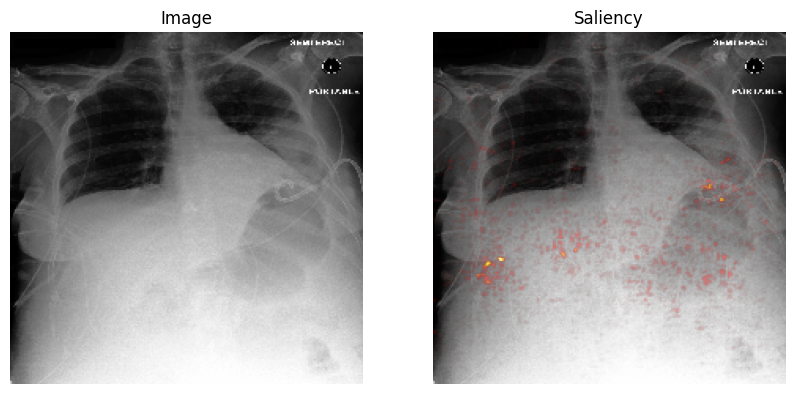

<Figure size 1000x500 with 0 Axes>

In [ ]:
plot_interpretability_measures(
    model, dataset = test_loader
)